In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Datasets/LungCancer"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Datasets/LungCancer

/content/drive/MyDrive/Datasets/LungCancer


In [ ]:
!pwd

/content/drive/MyDrive/Datasets/LungCancer


In [ ]:
!kaggle datasets download -d omarkhalil10/lung-cancer-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content/drive/MyDrive/Datasets/LungCancer. Or use the environment method.


In [ ]:
!du -hs /content/drive/MyDrive/Datasets/LungCancer

314M	/content/drive/MyDrive/Datasets/LungCancer


In [ ]:
!ls

'Bengin cases'	   'Normal cases'  'The IQ-OTHNCCD lung cancer dataset'
'Malignant cases'  'Test cases'


In [ ]:
!unzip lung-cancer-dataset.zip

unzip:  cannot find or open lung-cancer-dataset.zip, lung-cancer-dataset.zip.zip or lung-cancer-dataset.zip.ZIP.


#Importing Required Libraries

In [ ]:
import numpy as np  #to word with images and tensors
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm # to keep track of callbacks and progress bars
import skimage.io # use to deal with numpy images, it has 3 different channels for RGB respectively
import glob # used to return all file paths that match a specific pattern

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.utils import shuffle 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential # used to stack layers
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # callbacks

%matplotlib inline

In [ ]:
malignant = glob.glob('/content/drive/MyDrive/Datasets/LungCancer/train/Malignant cases/*.jpg')
bengin = glob.glob('/content/drive/MyDrive/Datasets/LungCancer/train/Benign cases/*.jpg')
normal = glob.glob('/content/drive/MyDrive/Datasets/LungCancer/train/Normal cases/*.jpg')

In [ ]:
len(malignant)

561

In [ ]:
len(bengin)

120

In [ ]:
len(normal)

422

In [ ]:

sizes = []
for i in tqdm(range(len(normal))):
  img = imread(normal[i])
  sizes.append(img.shape)


100%|██████████| 422/422 [00:06<00:00, 68.47it/s]


In [ ]:
from collections import Counter
print(Counter(sizes))

Counter({(512, 512, 3): 415, (358, 400, 3): 2, (225, 224, 3): 2, (552, 800, 3): 2, (331, 506, 3): 1})


In [ ]:
image = []
label = []

#0.Normal
for i in tqdm(range(len(normal))):
  img = imread(normal[i])
  img = resize(img, (224,224))
  image.append(img)
  label.append(0)

# 1. Malignant
for i in tqdm(range(len(malignant))):
  img = imread(malignant[i])
  img = resize(img, (224,224))
  image.append(img)
  label.append(1)

#2.Bengin
for i in tqdm(range(len(bengin))):
  img = imread(bengin[i])
  img = resize(img, (224,224))
  image.append(img)
  label.append(2)


100%|██████████| 120/120 [00:07<00:00, 15.97it/s]


In [ ]:
image = np.array(image)
label = np.array(label)
image.shape

(1103, 224, 224, 3)

In [ ]:
image, label = shuffle(image, label, random_state=52)

100%|██████████| 5/5 [00:00<00:00, 299.82it/s]


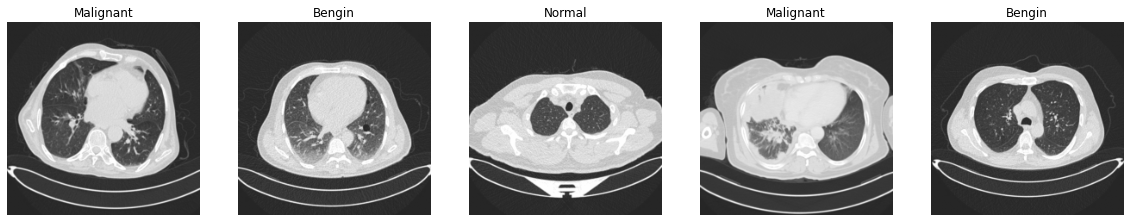

In [ ]:
# Viewing Image - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(image))
    ax[i].imshow(image[rand])
    ax[i].axis('off')
    a = label[rand]
    if a == 1:
        ax[i].set_title('Malignant')
    elif a==2:
        ax[i].set_title('Bengin')
    else:
      ax[i].set_title('Normal')

In [ ]:
del bengin
del malignant
del sizes
del img
del normal
del a


In [ ]:
from collections import Counter
shapes = []
for i in image:
  shapes.append(i.shape)
Counter(shapes)


Counter({(224, 224, 3): 1103})

In [ ]:

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
output_matrix = to_categorical(label, num_classes=3, dtype='float32')
output_matrix[:10]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
train_path = "/content/drive/MyDrive/Datasets/LungCancer/train"
test_path = "/content/drive/MyDrive/Datasets/LungCancer/test"
valid_path = "/content/drive/MyDrive/Datasets/LungCancer/valid"

In [ ]:
#set globals
BATCH_SIZE = 64
EPOCHS = 25
SEED = 49
IMAGE_SHAPE = (224,224,3)
N_CLASSES = 3
STEPS = 50

In [ ]:



train_datagen = ImageDataGenerator(dtype='float32')
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,244),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

Found 1258 images belonging to 3 classes.
Found 126 images belonging to 3 classes.
Found 469 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))




58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
dropout = layers.Dropout(0.5)
prediction_layer = layers.Dense(N_CLASSES, activation='softmax')


vgg16_model = models.Sequential([
    vgg16,
    flatten_layer,
    dense_layer_1,
    dropout,
    prediction_layer
])

In [ ]:
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
import tensorflow as tf
adam_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)
vgg16_model.compile(optimizer=adam_optimizer, 
                     loss='categorical_crossentropy',
                     metrics=['accuracy']) #need to update to use f1 score too

In [ ]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['acc'])


# Defining callbacks
filepath = '/content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5'

early_stopping = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min' , 
                              patience = 15)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [early_stopping, checkpoint]

In [ ]:
history_model = vgg16_model.fit(train_generator,
                               epochs = EPOCHS,
                               verbose = 1,
                               validation_data = valid_generator,
                               callbacks = [checkpoint, early_stopping])


Epoch 1/25
20/20 [==============================] - ETA: 0s - loss: 14.4976 - accuracy: 0.4436 
Epoch 1: val_loss improved from inf to 2.56004, saving model to /content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5
20/20 [==============================] - 389s 19s/step - loss: 14.4976 - accuracy: 0.4436 - val_loss: 2.5600 - val_accuracy: 0.8465
Epoch 2/25
20/20 [==============================] - ETA: 0s - loss: 6.3781 - accuracy: 0.6693
Epoch 2: val_loss improved from 2.56004 to 1.08492, saving model to /content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5
20/20 [==============================] - 18s 912ms/step - loss: 6.3781 - accuracy: 0.6693 - val_loss: 1.0849 - val_accuracy: 0.8934
Epoch 3/25
20/20 [==============================] - ETA: 0s - loss: 4.2629 - accuracy: 0.7345
Epoch 3: val_loss improved from 1.08492 to 0.72651, saving model to /content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5
20/20 [==============================] - 18s 882ms/step - loss: 4.262

In [ ]:
from sklearn.metrics import accuracy_score
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5')

pred_datagen = ImageDataGenerator(dtype='float32')
pred_generator = pred_datagen.flow_from_directory(valid_path,
                                            batch_size = BATCH_SIZE,
                                            target_size=(224,224),
                                            class_mode = 'categorical', 
                                            shuffle=False)
model_pred = model.predict(pred_generator)
pred = []
for i in model_pred:
  pred.append(np.argmax(i))

accuracy_score(pred_generator.classes, pred)





Found 469 images belonging to 3 classes.
8/8 [==============================] - 3s 391ms/step


0.9914712153518124

In [ ]:
# Evaluate the model
from sklearn.metrics import accuracy_score
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5')

test_datagen = ImageDataGenerator(dtype='float32')
test_generator = test_datagen.flow_from_directory(test_path,
                                            batch_size = BATCH_SIZE,
                                            target_size=(224,224),
                                            class_mode = 'categorical', 
                                            shuffle=False)
test_pred = model.predict(test_generator)
testpred = []
for i in test_pred:
  testpred.append(np.argmax(i))

accuracy_score(test_generator.classes, testpred)



Found 126 images belonging to 3 classes.
2/2 [==============================] - 23s 22s/step


0.9682539682539683

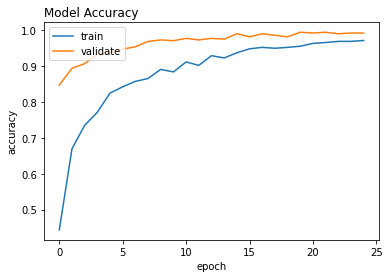

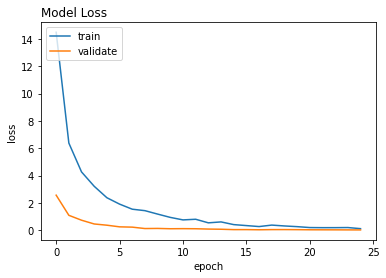

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# graph accuracy
#model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5')

plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model Accuracy', loc='left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model Loss', loc='left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [ ]:
# scores = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
# print(f"Test loss: {scores[0]}")
# print(f"Test accuracy: {scores[1]}")

In [ ]:
# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(testy, yhat_classes)
# print('Accuracy: %f' % accuracy)

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# precision tp / (tp + fp)
precision = precision_score(test_generator.classes, testpred, average= 'macro')
print('Precision: %f' % precision)


# recall: tp / (tp + fn)
recall = recall_score(test_generator.classes, testpred, average= 'macro')
print('Recall: %f' % recall)


# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_generator.classes, testpred, average= 'macro')
print('F1 score: %f' % f1)

Precision: 0.969555
Recall: 0.967276
F1 score: 0.967750


[[38  1  2]
 [ 0 45  0]
 [ 0  1 39]]


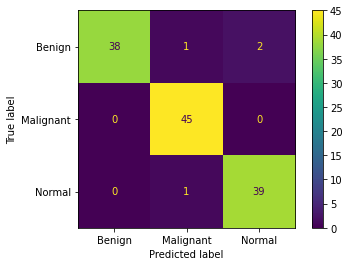

In [ ]:

# # kappa
# kappa = cohen_kappa_score(testy, yhat_classes)
# print('Cohens kappa: %f' % kappa)


# # ROC AUC
# auc = roc_auc_score(testy, yhat_probs)
# print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(test_generator.classes, testpred)
print(matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])

cm_display.plot()
plt.show()


#test_generator.class_indices.keys()

In [ ]:
# import tensorflow as tf
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt


# # Load the saved model
# model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5')

# # Load the test dataset
# test_data = np.load('/content/drive/MyDrive/Datasets/LungCancer/test')
# test_labels = ['Benign', 'Malignant', 'Normal'] #np.load('path/to/test_labels.npy')

# # Evaluate the model on the test dataset
# predictions = model.predict(test_data)
# predicted_labels = np.argmax(predictions, axis=1)

# # Compute the confusion matrix
# cm = confusion_matrix(test_labels, predicted_labels)

# # Plot the confusion matrix
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.colorbar()
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Compute the accuracy
# accuracy = np.mean(np.equal(test_labels, predicted_labels))

# # Plot the accuracy
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(test_labels, predicted_labels, 'o', alpha=0.5)
# plt.xlabel('True Label')
# plt.ylabel('Predicted Label')
# plt.title('Accuracy: {:.2f}%'.format(accuracy*100))
# plt.show()


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-101-5e54af664628>", line 11, in <module>
    test_data = np.load('/content/drive/MyDrive/Datasets/LungCancer/test')
  File "/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py", line 407, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/Datasets/LungCancer/test'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IsADirectoryError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent 

IsADirectoryError: ignored

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(image, label, stratify=label)

In [ ]:
# Counter(y_train), Counter(y_test)

(Counter({1: 420, 0: 321, 2: 90}), Counter({0: 107, 1: 141, 2: 30}))

In [ ]:
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)

In [ ]:
# datagen = ImageDataGenerator(dtype='float32',
#                                    rescale = 1./255.,)
# datagen.fit(x_train)
# #train_generator = train_datagen.flow(x_train, y_train, batch_size=32, subset='training')


# # valid_datagen = ImageDataGenerator(dtype='float32',
# #                                    rescale=1./255.)
# # valid_generator = train_datagen.flow(x_valid, y_valid, batch_size=32, subset ='valid')

In [ ]:
# model = Sequential()

# # Input Layer
# model.add(InputLayer(input_shape=(224,224,3)))

# # Adding layers
# model.add(Conv2D(filters = 64,   kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 64,   kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size = (2, 2), strides=(2,2)))


# model.add(Conv2D(filters = 128,   kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 128,   kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size = (2, 2), strides=(2,2)))


# model.add(Conv2D(filters = 256,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 256,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 256,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size = (2, 2), strides=(2,2)))


# model.add(Conv2D(filters = 512,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 512,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 512,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size = (2, 2), strides=(2,2)))


# model.add(Conv2D(filters = 512,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 512,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(filters = 512,  kernel_size  = (3, 3), padding='same', activation='relu'))
# model.add(MaxPool2D(pool_size = (2, 2), strides=(2,2)))


# # Adding flatten
# model.add(Flatten())


# # Adding full connected layer (dense)
# model.add(Dense(units = 4096, activation = 'relu'))
# model.add(Dense(units = 4096, activation = 'relu'))


# # Adding output layer
# model.add(Dense(units = 3, activation='softmax'))

In [ ]:
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
# model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['acc'])
# # Defining callbacks
# filepath = '/content/drive/MyDrive/LungCancer/models/best_weights.hdf5'

# earlystopping = EarlyStopping(monitor = 'accuracy', 
#                               mode = 'max' , 
#                               patience = 10)

# checkpoint    = ModelCheckpoint(filepath, 
#                                 monitor = 'accuracy', 
#                                 mode='max', 
#                                 save_best_only=True, 
#                                 verbose = 1)

# callback_list = [earlystopping, checkpoint]

In [ ]:
# EPOCHS=50
# BATCH_SIZE = 32
# model.fit(datagen.flow(x_train, y_train, batch_size=200),
#           validation_data = datagen.flow(x_test, y_test, batch_size=32),
#           epochs = EPOCHS,
#           verbose = 1,
#           callbacks = callback_list)

Epoch 1/50


In [ ]:
# ALEXNET

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:

# Define the input shape
input_shape = (224, 224, 3)


In [ ]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization



# Define the model architecture
model = Sequential([
    # Convolutional layers
    Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=3, strides=2),
    Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
    MaxPooling2D(pool_size=3, strides=2),
    Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=3, strides=2),
    # Flatten layer
    Flatten(),
    # Fully connected layers
    Dense(units=4096, activation='relu'),
    Dropout(0.5),
    Dense(units=4096, activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(units=3, activation='softmax')
])




# input_shape = (224, 224)

# model = Sequential()
# # Layer 1
# model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=input_shape, padding='valid'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# # Layer 2
# model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# # Layer 3
# model.add(ZeroPadding2D((1, 1)))
# model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))

# # Layer 4
# model.add(ZeroPadding2D((1, 1)))
# model.add(Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))

# # Layer 5
# model.add(ZeroPadding2D((1, 1)))
# model.add(Conv2D(1024, (3, 3), strides=(1, 1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# # Layer 6
# model.add(Flatten())
# model.add(Dense(4096))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# # Layer 7
# model.add(Dense(4096))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# # Layer 8
# model.add(Dense(3))
# model.add(Activation('softmax'))

#model.summary()



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [ ]:

# Data augmentation
#train_datagen = ImageDataGenerator(dtype = 'float32')


In [ ]:


train_datagen = ImageDataGenerator(dtype='float32')
train_gen = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = input_shape[:2],
                                                   class_mode = 'categorical')



valid_datagen = ImageDataGenerator(dtype='float32')
validation_gen = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = input_shape[:2],
                                                   class_mode = 'categorical')


Found 1258 images belonging to 3 classes.
Found 469 images belonging to 3 classes.


In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Defining callbacks
filepath = '/content/drive/MyDrive/Datasets/LungCancer/models/alexnet.hdf5'

early_stopping = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min' , 
                              patience = 15)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [early_stopping, checkpoint]

In [ ]:
# Train the model
# history_model = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,
#     epochs=10,
#     callbacks = [checkpoint, early_stopping]
# )
# EPOCHS = 15
history_model = model.fit(train_gen,
                               epochs = 30,
                               verbose = 1,
                               validation_data = validation_gen,
                               callbacks = [checkpoint, early_stopping])


Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 100.0779 - accuracy: 0.4563
Epoch 1: val_loss improved from inf to 0.88507, saving model to /content/drive/MyDrive/Datasets/LungCancer/models/alexnet.hdf5
20/20 [==============================] - 249s 12s/step - loss: 100.0779 - accuracy: 0.4563 - val_loss: 0.8851 - val_accuracy: 0.2708
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.4706
Epoch 2: val_loss did not improve from 0.88507
20/20 [==============================] - 137s 7s/step - loss: 0.9741 - accuracy: 0.4706 - val_loss: 0.8901 - val_accuracy: 0.6930
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.9431 - accuracy: 0.5032
Epoch 3: val_loss improved from 0.88507 to 0.86815, saving model to /content/drive/MyDrive/Datasets/LungCancer/models/alexnet.hdf5
20/20 [==============================] - 142s 7s/step - loss: 0.9431 - accuracy: 0.5032 - val_loss: 0.8681 - val_accuracy: 0.7420
Epoch 4/30
20/20 [

In [ ]:
from sklearn.metrics import accuracy_score
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/alexnet.hdf5')


#VALIDATION DATA

pred_datagen = ImageDataGenerator(dtype='float32')
pred_gen = pred_datagen.flow_from_directory(valid_path,
                                            batch_size = BATCH_SIZE,
                                            target_size=(224,224),
                                            class_mode = 'categorical', 
                                            shuffle=False)
model_pred = model.predict(pred_gen)
pred = []
for i in model_pred:
  pred.append(np.argmax(i))

accuracy_score(pred_gen.classes, pred)

Found 469 images belonging to 3 classes.
8/8 [==============================] - 13s 2s/step


0.9872068230277186

In [ ]:

# Evaluate the model - TEST DATA

from sklearn.metrics import accuracy_score
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/alexnet.hdf5')

test_datagen = ImageDataGenerator(dtype='float32')
test_gen = test_datagen.flow_from_directory(test_path,
                                            batch_size = BATCH_SIZE,
                                            target_size=(224,224),
                                            class_mode = 'categorical', 
                                            shuffle=False)
test_pred = model.predict(test_gen)
testpred = []
for i in test_pred:
  testpred.append(np.argmax(i))

accuracy_score(test_gen.classes, testpred)



Found 126 images belonging to 3 classes.
2/2 [==============================] - 14s 5s/step


0.9841269841269841

In [ ]:

scores = model.evaluate(test_gen, steps=test_gen.samples // test_gen.batch_size)
print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")


1/1 [==============================] - 1s 734ms/step - loss: 0.0236 - accuracy: 0.9844
Test loss: 0.02359570935368538
Test accuracy: 0.984375


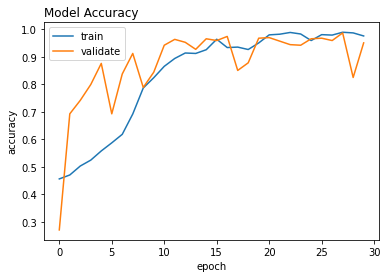

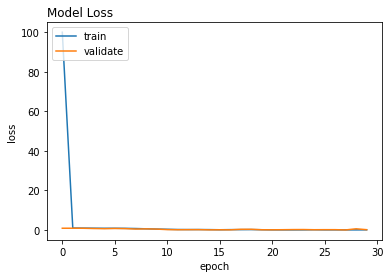

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# graph accuracy
#model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/alexnet.hdf5')

plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model Accuracy', loc='left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model Loss', loc='left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(testy, yhat_classes)
# print('Accuracy: %f' % accuracy)

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# precision tp / (tp + fp)
precision = precision_score(test_gen.classes, testpred, average= 'macro')
print('Precision: %f' % precision)


# recall: tp / (tp + fn)
recall = recall_score(test_gen.classes, testpred, average= 'macro')
print('Recall: %f' % recall)


# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_gen.classes, testpred, average= 'macro')
print('F1 score: %f' % f1)


Precision: 0.985816
Recall: 0.983120
F1 score: 0.984205


[[40  1  0]
 [ 0 45  0]
 [ 0  1 39]]


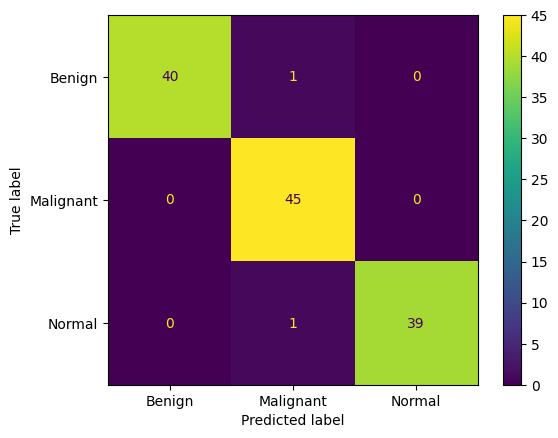

dict_keys(['Benign cases', 'Malignant cases', 'Normal cases'])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# # kappa
# kappa = cohen_kappa_score(testy, yhat_classes)
# print('Cohens kappa: %f' % kappa)


# # ROC AUC
# auc = roc_auc_score(testy, yhat_probs)
# print('ROC AUC: %f' % auc)


# confusion matrix
matrix = confusion_matrix(test_gen.classes, testpred)
print(matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['Benign', 'Malignant', 'Normal'])

cm_display.plot()
plt.show()


test_gen.class_indices.keys()

In [ ]:
# Calculate the specificity and sensitivity from the confusion matrix
# tn, fp, fn, tp = matrix.ravel().split(",")

# tn = int(tn)
# fn = int(fp)
# fn = int(fn)
# tp = int(tp)

# specificity = tn / (tn + fp)
# sensitivity = tp / (tp + fn)

# def specificity(confusion_matrix):
#     tn, fp, fn, tp = confusion_matrix.ravel()
#     return tn / (tn + fp)

# def sensitivity(confusion_matrix):
#     tn, fp, fn, tp = confusion_matrix.ravel()
#     return tp / (tp + fn)

# # Print the results
# print('Specificity:', specificity(matrix))
# print('Sensitivity:', sensitivity(matrix))

tp = matrix[0][0] + matrix[1][1] + matrix[2][2]
tn = (matrix[1][1] + matrix[1][2] + matrix[2][1] + matrix[2][2]) + (matrix[0][0] + matrix[0][2] + matrix[2][0] + matrix[2][2]) + (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1]) 
fp = matrix[1][0] + matrix[2][0] +  matrix[0][1] + matrix[2][1] + matrix[0][2] + matrix[1][2]
fn = matrix[0][1] + matrix[0][2] + matrix[1][0] + matrix[1][2] + matrix[2][0] + matrix[2][1]
print(tp)
print(tn)
print(fp)
print(fn)

precision = tp / (tp + fp)
print('Precision: %f' % precision)

recall = tp / (tp + fn)
print('Recall: %f' % recall)


f1 = 2*tp / (2*tp + fp + fn)
print('F1 score: %f' % f1)


122
246
2
2
Precision: 0.983871
Recall: 0.983871
F1 score: 0.983871


In [ ]:
# DETECTION - USER OPERATED - VGG16 MODEL

import cv2
import tensorflow as tf
import numpy as np
from google.colab import files

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/vgg16.hdf5')

# Define the classes
classes = ['Benign Lung Cancer', 'Malignant Lung Cancer', 'Normal']

# Browse for the test image
uploaded = files.upload()

# Loop through all the uploaded images
for image_path in uploaded.keys():
  # Load the test image and preprocess it
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224, 224))
  image = np.expand_dims(image, axis=0)

  # Predict the label of the test image
  predictions = model.predict(image)
  predicted_class = np.argmax(predictions)

  # Print the predicted class
  print(f"Image '{image_path}': Predicted class: {classes[predicted_class]}")



Saving Bengin case (77).jpg to Bengin case (77).jpg
Saving Bengin case (78) - Copy.jpg to Bengin case (78) - Copy.jpg
Saving Bengin case (78).jpg to Bengin case (78).jpg
Saving Bengin case (82).jpg to Bengin case (82).jpg
Saving Bengin case (97).jpg to Bengin case (97).jpg
Saving Bengin case (98).jpg to Bengin case (98).jpg
Saving Bengin case (102).jpg to Bengin case (102).jpg
Saving Bengin case (103).jpg to Bengin case (103).jpg
Saving Bengin case (111).jpg to Bengin case (111).jpg
Saving Bengin case (112).jpg to Bengin case (112).jpg
Saving Bengin case (113).jpg to Bengin case (113).jpg
Saving Bengin case (114).jpg to Bengin case (114).jpg
1/1 [==============================] - 1s 793ms/step
Image 'Bengin case (77).jpg': Predicted class: Benign Lung Cancer
1/1 [==============================] - 0s 21ms/step
Image 'Bengin case (78) - Copy.jpg': Predicted class: Benign Lung Cancer
1/1 [==============================] - 0s 20ms/step
Image 'Bengin case (78).jpg': Predicted class: Benign 

In [ ]:
# DETECTION - USER OPERATED - ALEXNET MODEL

import cv2
import tensorflow as tf
import numpy as np
from google.colab import files

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/LungCancer/models/alexnet.hdf5')

# Define the classes
classes = ['Benign Lung Cancer', 'Malignant Lung Cancer', 'Normal']

# Browse for the test image
uploaded = files.upload()

# Loop through all the uploaded images
for image_path in uploaded.keys():
  # Load the test image and preprocess it
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224, 224))
  image = np.expand_dims(image, axis=0)

  # Predict the label of the test image
  predictions = model.predict(image)
  predicted_class = np.argmax(predictions)

  # Print the predicted class
  print(f"Image '{image_path}': Predicted class: {classes[predicted_class]}")



Saving 000004 (4).png to 000004 (4).png
Saving 000013 (8).png to 000013 (8).png
Saving 000017 (6).png to 000017 (6).png
1/1 [==============================] - 0s 90ms/step
Image '000004 (4).png': Predicted class: Malignant Lung Cancer
1/1 [==============================] - 0s 24ms/step
Image '000013 (8).png': Predicted class: Malignant Lung Cancer
1/1 [==============================] - 0s 19ms/step
Image '000017 (6).png': Predicted class: Malignant Lung Cancer
